In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

pd.options.display.max_rows = 10
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train = pd.read_csv('../input/train.csv')
print('train.shape', train.shape)

test = pd.read_csv('../input/test.csv')
print('test.shape',test.shape)

train.shape (42000, 785)
test.shape (28000, 784)


In [3]:
y_train = train.iloc[:, 0]
X_train = train.iloc[:, 1:]

X_test = test

del train, test

In [4]:
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

In [5]:
X_train = (X_train/255.0).values.reshape(42000, 28, 28, 1)
X_test = (X_test/255.0).values.reshape(28000, 28, 28, 1)
y_train = to_categorical(y_train, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((37800, 28, 28, 1),
 (37800, 10),
 (4200, 28, 28, 1),
 (4200, 10),
 (28000, 28, 28, 1))

(-0.5, 27.5, 27.5, -0.5)

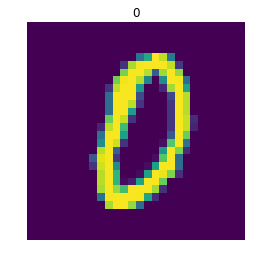

In [6]:
plt.imshow(X_train[11].reshape(28, 28))
plt.title(np.argmax(y_train[11]))
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

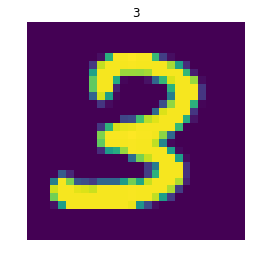

In [7]:
plt.imshow(X_val[0].reshape(28, 28))
plt.title(np.argmax(y_val[0]))
plt.axis('off')

In [9]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu', padding = 'Same'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation = 'relu'))

model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units = 10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [10]:
data_augmentation = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False
)

data_augmentation.fit(X_train)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((37800, 28, 28, 1),
 (37800, 10),
 (4200, 28, 28, 1),
 (4200, 10),
 (28000, 28, 28, 1))

In [14]:
batch_size = 128
epochs = 2

In [15]:
hist = model.fit_generator(data_augmentation.flow(X_train, y_train, batch_size=batch_size),
                          epochs = epochs, validation_data = (X_val, y_val),
                          steps_per_epoch=X_train.shape[0], callbacks=[learning_rate_reduction])

Epoch 1/2
37800/37800 [==============================] - 1773s 47ms/step - loss: 0.0186 - acc: 0.9942 - val_loss: 0.0120 - val_acc: 0.9971
Epoch 2/2
37800/37800 [==============================] - 1812s 48ms/step - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0165 - val_acc: 0.9967


In [16]:
hist = pd.DataFrame(hist.history)

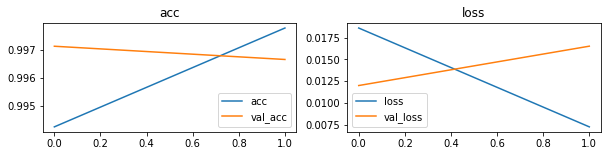

In [17]:
plt.figure(figsize=(10,2))

plt.subplot(1, 2, 1)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.title('acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('loss')
plt.legend()

plt.show()

In [23]:
predict_y = model.predict(X_test)

In [24]:
predict_y = np.apply_along_axis(np.argmax, 1, predict_y)
predict_y[:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

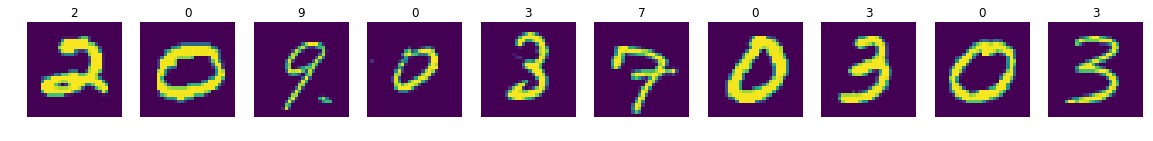

In [20]:
plt.figure(figsize=(20, 6))

n = 10
for i in range(n):
  plt.subplot(1, n, i+1)
  plt.imshow(X_test[i].reshape(28, 28))
  plt.title(np.argmax(predict_y[i]))
  plt.axis('off')

In [25]:
output = pd.DataFrame()
output['ImageId'] = np.arange(1, 28000+1)
output['Label'] = predict_y

output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [ ]:
output.to_csv('submission.csv', index=False)